In [1]:
"""
project for internship for VIE

"""
from sklearn.preprocessing import OneHotEncoder

import plotly.express as px

from selenium.webdriver.firefox.service import Service
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import time
import glob
import numpy as np
import requests
import pandas as pd
import json
import ast
import re

In [2]:
api_url = "https://tankertrackers.com/api/sanctioned/v1"
response = requests.get(api_url)
j = response.json()

sanction_data = pd.DataFrame.from_dict(j["data"])
country_sanctions = sanction_data["sanctions"].apply(pd.Series)
print(f"sanctioned data {country_sanctions.shape}")
sanction_fleet = pd.concat([sanction_data.drop("sanctions", axis=1), country_sanctions], axis=1)

f"tanker tracker count: {sanction_fleet.shape}"

sanctioned data (1209, 7)


'tanker tracker count: (1209, 9)'

In [3]:
vessels = pd.read_excel('Book1.xlsx')
vessels

,name,class_size,flag
0,A JEWEL (9244867),VLCC/ULCC,Cook Islands
1,A R G (9689031),Handysize/Handymax,Barbados
2,A S (7303803),Handysize/Handymax,North Korea
3,ABHRA (9282041),Aframax,Panama
4,ABROS (9247388),Handysize/Handymax,Curaçao
...,...,...,...
1204,ZARYA (9953535),Aframax,Russia
1205,ZEAL (9486805),Handysize/Handymax,Gabon
1206,ZENITH (9157765),Aframax,Guyana
1207,ZENITH (9610781),Suezmax,Comoros


In [4]:
pattern = r'\((\d+\.?\d*)\)'

# Find all matches of the pattern in the text
# numbers_in_parentheses = re.findall(pattern, text)

vessels['imo'] = [re.findall(pattern, text) for text in vessels.name] # Matches integers and floats
# [re.sub(r'[\[\]()]', '', text) for text in vessels.imo.values]
vessels['imo'] = [int(x[0]) for x in vessels.imo.values]
# vessels['
vessels.sort_values(by='imo').flag.unique()

array(['North Korea', 'Saint Vincent and the Grenadines', 'Tanzania',
       'Russia', 'Iran', 'Sierra Leone', 'Aruba', 'Eswatini', 'Palau',
       'Panama', 'Curaçao', 'Gambia', 'Cameroon', 'China', 'Guyana',
       'Comoros', 'Dominica', 'Djibouti', 'Honduras', 'Mali', 'Guinea',
       'Thailand', 'Benin', 'Venezuela', 'Hong Kong', 'Angola',
       'Sao Tome and Principe', 'Marshall Islands', 'Cook Islands',
       'Gabon', 'Guinea-Bissau', 'Indonesia', 'Bahamas', 'Tonga',
       'Barbados', 'Nigeria', 'Vietnam', 'San Marino', 'Antigua Barbuda',
       'Malawi', 'Saint Kitts and Nevis', 'Brazil', 'Mozambique',
       'Vanuatu', 'Liberia', 'Jamaica', 'Cuba', 'Azerbaijan', 'India',
       'Oman', 'Germany', 'Belize', 'Portugal', 'Malaysia', 'Singapore',
       'Philippines'], dtype=object)

In [5]:
vessels.query('imo==8106496')

,name,class_size,flag,imo
899,SAMMA2 (8106496),Handysize/Handymax,North Korea,8106496


In [ ]:
"""
code used to concat scraped data, merge with TT api data to create csv of data
"""

scraped = pd.concat(
    map(pd.read_csv, glob.glob("scraped*.csv"))
)
cols = list(scraped.columns)
scraped = scraped.reset_index(drop=True)
scraped=scraped[~scraped.DWT.isna()]
print(f" raw scraped data : {scraped.shape}")


scraped = scraped.drop_duplicates(subset=cols)
scraped['build_year'] = pd.to_numeric(scraped['build_year'], errors='coerce')
scraped['gross_tonnage'] = pd.to_numeric(scraped['gross_tonnage'], errors='coerce')
scraped['DWT'] = pd.to_numeric(scraped['DWT'], errors='coerce')
scraped=scraped[~scraped.build_year.isna()]
scraped = scraped.sort_values(by="imo").reset_index(drop=True)
scraped.to_csv("final_dwt_data.csv", index=False)
print(f" refined scraped data: {scraped.shape}")


df_sanction_fleet = pd.merge(sanction_fleet, scraped, how="outer", on="imo")


df_sanction_fleet = df_sanction_fleet.drop('name_y', axis=1)
df_sanction_fleet = df_sanction_fleet.rename(columns={'name_x':'name'})
df_sanction_fleet['imo'] = df_sanction_fleet.imo.astype('str')
df_sanction_fleet['ship_type'] = df_sanction_fleet.ship_type.astype('str')
df_sanction_fleet = df_sanction_fleet.sort_values(by='imo')

df_sanction_fleet['ship_type'] = [name.lower() for name in df_sanction_fleet.ship_type]

def count_sanctions(data):
    df_sanction_fleet[f"{data}_numeric"] = np.where(df_sanction_fleet[f"{data}"].notna(), 1, 0)

    return df_sanction_fleet

categorical_bans=list(sanction_fleet.columns[2:9:])

[count_sanctions(d) for d in categorical_bans]

df_sanction_fleet['total_sanctions'] = df_sanction_fleet[df_sanction_fleet.columns[-7:]].sum(axis=1)

# df_sanction_fleet.to_csv('sanctioned_fleet_data.csv', index=False)
print('done')
"""

In [7]:
df = pd.read_csv('sanctioned_fleet_data.csv')


# Shoutout to @oilBandit@x.com who gave away darkfleet data sometime around March 5th 2023 on Twitter? Pre Elon!
oilBandit_data = pd.read_csv("Shadow_Fleet_oilBandit.csv")

columns = [str.lower(x.replace(" ","_")) for x in oilBandit_data.columns]
oilBandit_data.columns = columns
oilBandit_data["controller"] = [str(x).lower() for x in oilBandit_data["controller"]]
oilBandit_data = oilBandit_data.rename(columns={"name_of_ship":"name","year_of_build":"build_year"})
# oilBandit_data['imo'] = oilBandit_data.imo.astype(str)
# oilBandit_data.info()

df =pd.merge(df, oilBandit_data, on='imo', how='left', suffixes=('_TankerTrackers', '_oilBandit'))
df = pd.merge(df, vessels, on='imo', how='left', suffixes=('_', '_TTwebsite'))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204 entries, 0 to 1203
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   name_TankerTrackers           1204 non-null   object 
 1   imo                           1204 non-null   int64  
 2   OFAC                          666 non-null    object 
 3   UANI                          543 non-null    object 
 4   ASO                           60 non-null     object 
 5   EU                            436 non-null    object 
 6   FCDO                          435 non-null    object 
 7   GAC                           293 non-null    object 
 8   UN                            19 non-null     object 
 9   ship_type                     1204 non-null   object 
 10  build_year_TankerTrackers     1204 non-null   int64  
 11  gross_tonnage_TankerTrackers  1204 non-null   int64  
 12  DWT                           1204 non-null   int64  
 13  OFA

In [9]:
df[df.class_size.isna()].DWT

216    106131
Name: DWT, dtype: int64

In [29]:
pie_chart = df.groupby(['class_size']).count()

pie_chart = pie_chart.reset_index()
pie_chart = pie_chart.rename(columns={'name':'total_vessels'})

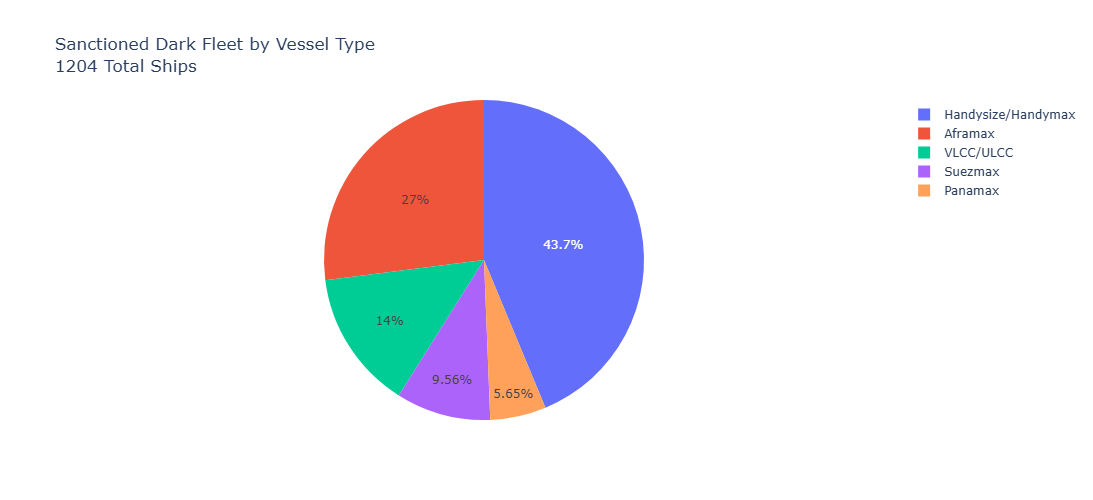

In [30]:
fig = px.pie(pie_chart, values='total_vessels', names='class_size', title=f"Sanctioned Dark Fleet by Vessel Type <br>{df.shape[0]} Total Ships")
fig.update_layout(width=500, height=500)
fig.show()
fig.write_html("piechart_interactive_plot.html")


In [31]:
oil_ships = df.query('class_size=="Suezmax" or class_size=="VLCC/ULCC" or class_size=="Aframax"')
f"ships that transport oil: {oil_ships.shape[0]}"


'ships that transport oil: 609'

In [32]:
# build year legit webscrape and oilBandit data
(oil_ships.build_year_oilBandit - oil_ships.build_year_TankerTrackers).sum()

np.float64(0.0)

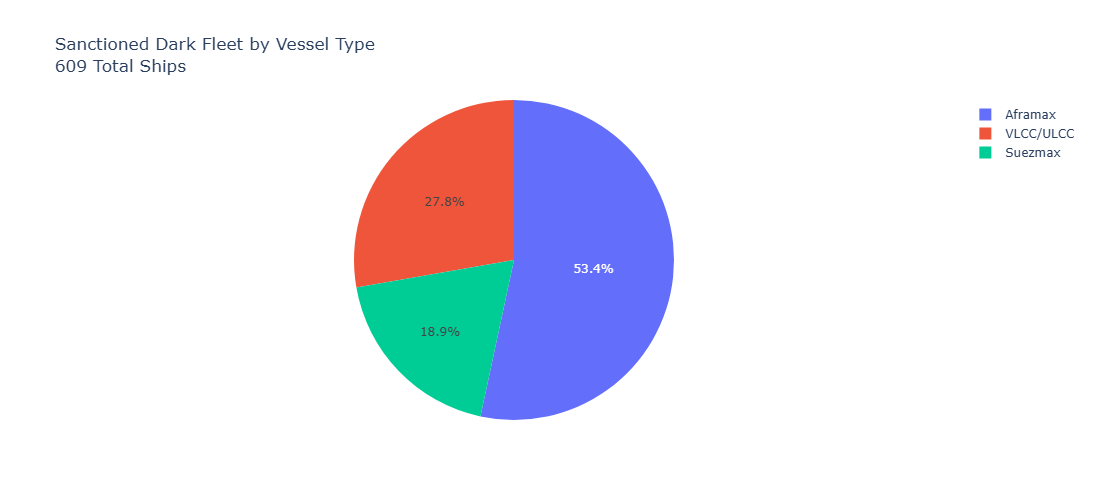

In [34]:
pie_chart = oil_ships.groupby(['class_size']).count()

pie_chart = pie_chart.reset_index()
pie_chart = pie_chart.rename(columns={'name':'total_vessels'})
fig = px.pie(pie_chart, values='total_vessels', names='class_size', title=f"Sanctioned Dark Fleet by Vessel Type <br>{oil_ships.shape[0]} Total Ships")
fig.update_layout(width=500, height=500)
fig.show()
fig.write_html("oil_piechart_interactive_plot.html")

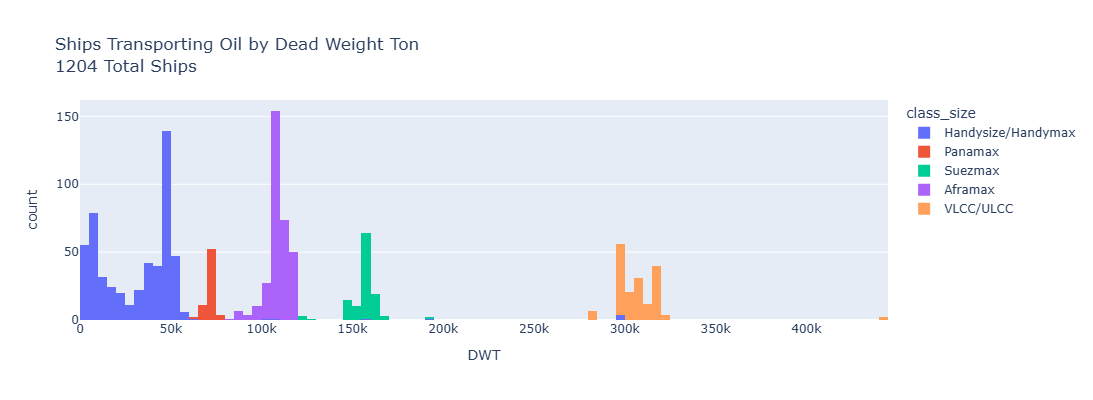

In [38]:
fig = px.histogram(df, x="DWT", color="class_size", nbins=100, title=f"Ships Transporting Oil by Dead Weight Ton <br>"
                                                                            f"{df.shape[0]} Total Ships")
fig.update_layout(width=900, height=400)
fig.show()
# fig.write_html("all_ships_dwt_interactive_plot.html")


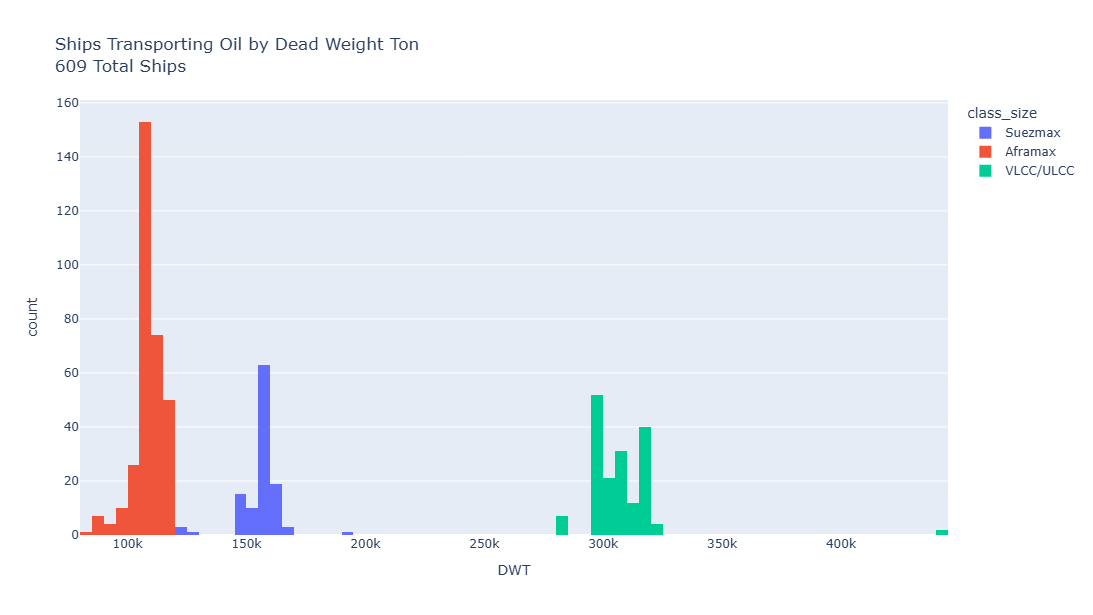

In [16]:
fig = px.histogram(oil_ships, x="DWT", color="class_size", nbins=100, title=f"Ships Transporting Oil by Dead Weight Ton <br>"
                                                                            f"{oil_ships.shape[0]} Total Ships")
fig.update_layout(width=1200, height=600)
fig.show()
fig.write_html("oil_ships_dwt_interactive_plot.html")


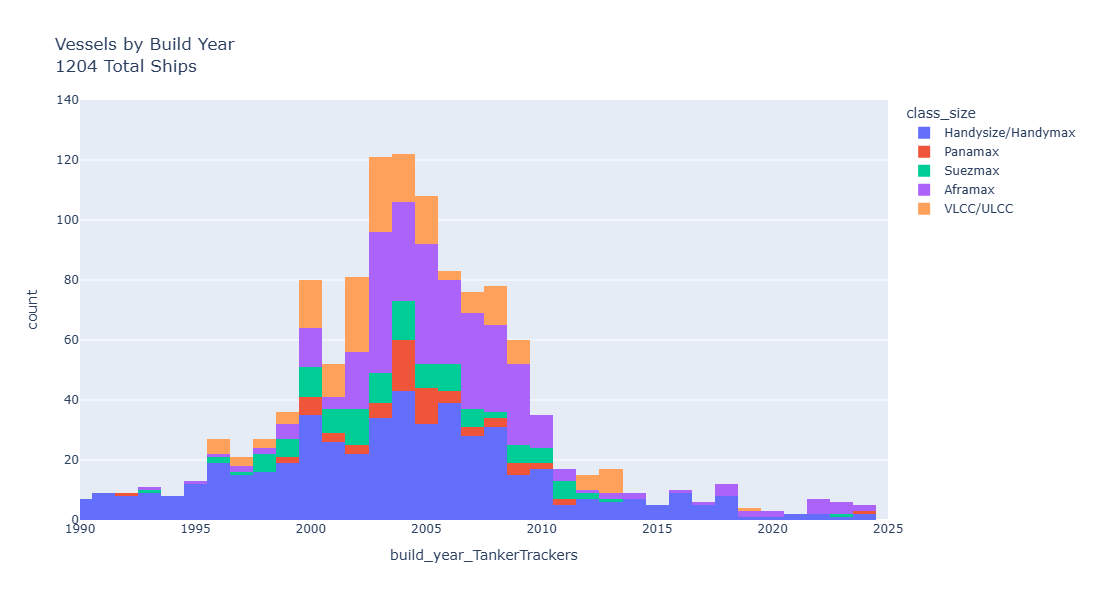

In [46]:
fig = px.histogram(df, x="build_year_TankerTrackers", color="class_size", nbins=100, title=f"Vessels by Build Year <br>"
                                                                            f"{df.shape[0]} Total Ships")
fig.update_layout(width=900, height=600)
fig.update_layout(
    xaxis=dict(range=[1990, 2025]),  # Sets x-axis range
    yaxis=dict(range=[0, 140])  # Sets -axis range
)

fig.show()
fig.write_html("all_ships_year_interactive_plot.html")


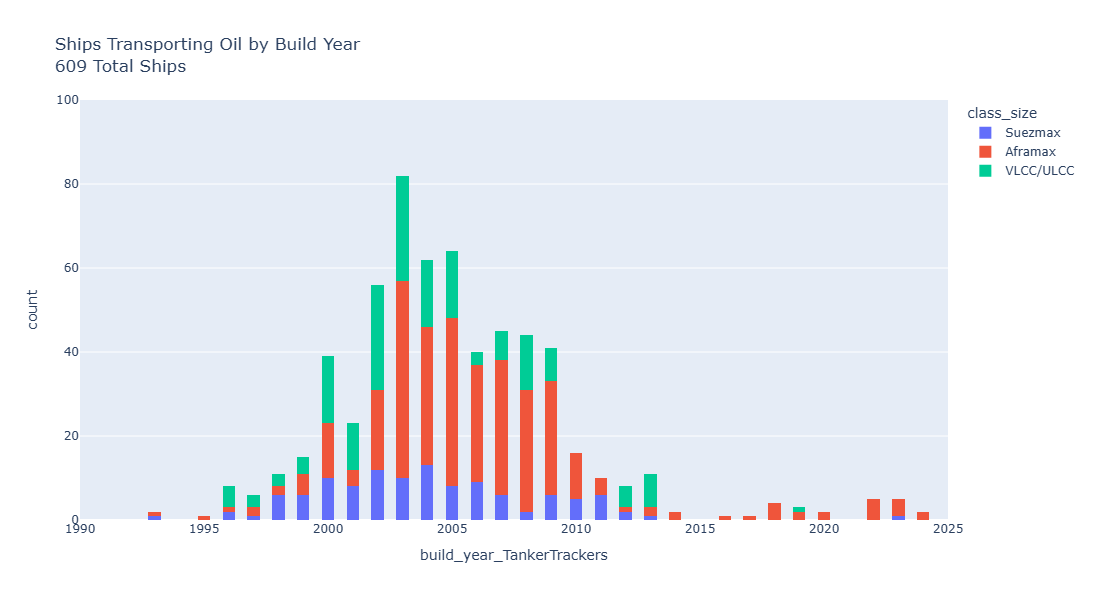

In [45]:
fig = px.histogram(oil_ships, x="build_year_TankerTrackers", color="class_size", nbins=100, title=f"Ships Transporting Oil by Build Year <br>"
                                                                            f"{oil_ships.shape[0]} Total Ships")
fig.update_layout(width=900, height=600)
fig.update_layout(
    xaxis=dict(range=[1990, 2025]),  # Sets x-axis range
    yaxis=dict(range=[0, 100])  # Sets -axis range
)

fig.show()
fig.write_html("oil_ships_year_interactive_plot.html")


In [18]:
binned_data_equal_width = pd.cut(oil_ships.DWT, bins=50)

# Bin data into custom-defined bins
custom_bins = np.array([0, 25, 50, 100, 150,275, np.inf])*1000
custom_bins

array([     0.,  25000.,  50000., 100000., 150000., 275000.,     inf])

In [19]:
binned_data_custom = pd.cut(oil_ships.DWT, bins=custom_bins, include_lowest=False, right=True) # right=False for [lower, upper) intervals

# You can then count the occurrences in each bin
bin_counts = binned_data_custom.value_counts().sort_index()
bin_counts.index.tolist()
# f"x.
binned_data_custom.cat.categories.right[-1]
# oil_ships.query('DWT<0')

np.float64(inf)

In [20]:
# make categorical values for binned plot 
cats = []
for idx, x in enumerate(binned_data_custom.cat.categories):
    left = f"{x.left:.0f}"
    right = f"{x.right:.0f}"
    if right=="inf":
        cats.append((f"{int(left):,} + DWT"))
    else:
        cats.append((f"{int(left):,} to {int(right):,} DWT"))
cats

['0 to 25,000 DWT',
 '25,000 to 50,000 DWT',
 '50,000 to 100,000 DWT',
 '100,000 to 150,000 DWT',
 '150,000 to 275,000 DWT',
 '275,000 + DWT']

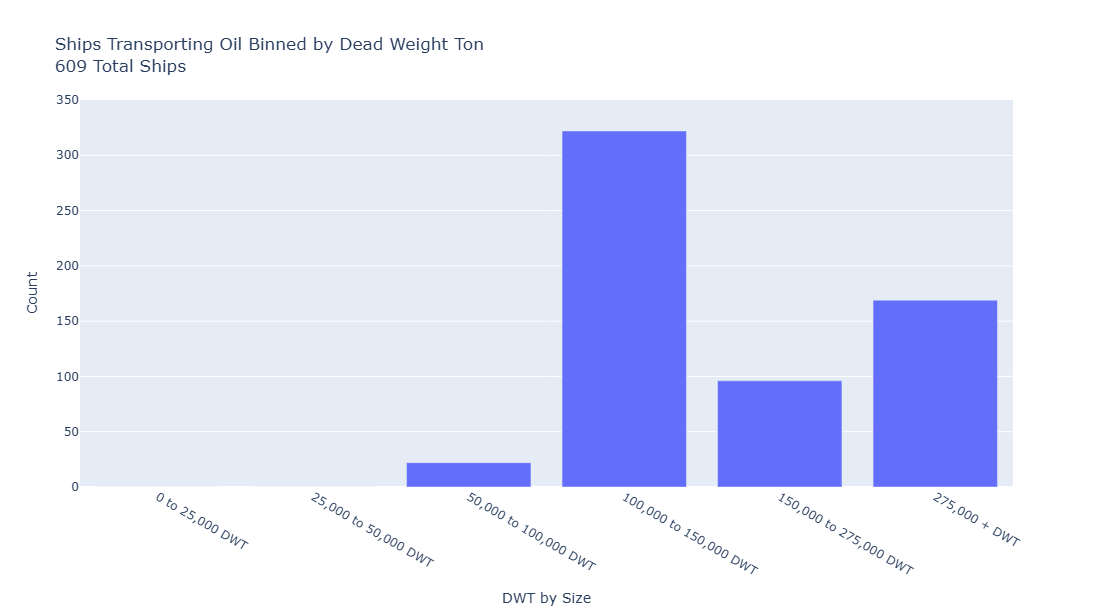

In [21]:
fig = px.bar(x=cats, y=bin_counts.values, title=f"Ships Transporting Oil Binned by Dead Weight Ton <br>"
                                                                            f"{oil_ships.shape[0]} Total Ships")
fig.update_layout(width=1200, height=600)
fig.update_layout(
    xaxis_title="DWT by Size",  # Set the x-axis title
    yaxis_title="Count"  # Set the y-axis title
)
fig.update_layout(
    yaxis=dict(range=[0, 350])  # Sets y-axis range from 0 to 20
)

fig.show()
fig.write_html("oil_ships_dwt_binned_interactive_plot.html")


In [24]:
minvlcc = df.query('class_size=="VLCC/ULCC"').DWT.min()
minvlcc

281037

In [25]:
df.query('DWT==@minvlcc').iloc[0]

name_TankerTrackers                       ANDROMEDA V
imo                                           9197832
OFAC                                         5/8/2025
UANI                                        11/1/2022
ASO                                               NaN
EU                                                NaN
FCDO                                              NaN
GAC                                               NaN
UN                                                NaN
ship_type                            crude oil tanker
build_year_TankerTrackers                        2000
gross_tonnage_TankerTrackers                   149282
DWT                                            281037
OFAC_numeric                                        1
UANI_numeric                                        1
ASO_numeric                                         0
EU_numeric                                          0
FCDO_numeric                                        0
GAC_numeric                 

In [ ]:
# the above readout confirm that the DWT is accurate.  gross_tonnage matches the webscrape!

In [ ]:
# TT gives class size, this filtering is moot

# possible_vlccs = df.query('DWT>=280000').reset_index(drop=True)
# f"size of possible VLCC list {possible_vlccs.shape[0]}"

# possible_vlccs[possible_vlccs.vessel_size.isna()].ship_type.unique()

# # remove fso from vlcc data
# idx = possible_vlccs.query('vessel_size=="fso" or ship_type=="fso"').index.tolist()
# vlccs = possible_vlccs[~possible_vlccs.index.isin(idx)]

# f"size of VLCC list {vlccs.shape[0]}"
# #stick season cover by our last night email 

# vlccs

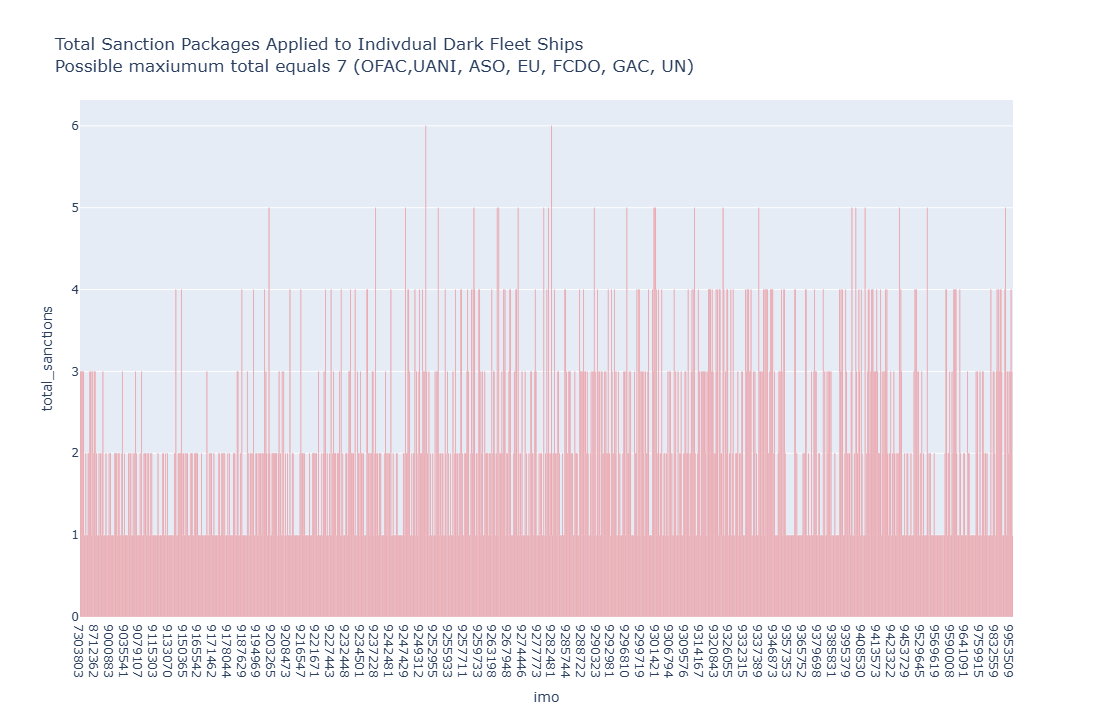

In [26]:
df['imo'] = df.imo.astype(str)
df = df.sort_values(by='imo').reset_index(drop=True)

fig = px.bar(df, x='imo', y='total_sanctions', color_discrete_sequence=['red'], title='Total Sanction Packages Applied to Indivdual Dark Fleet Ships<br>'
                                                                      'Possible maxiumum total equals 7 (OFAC,UANI, ASO, EU, FCDO, GAC, UN)')
fig.update_layout(width=1400, height=700)
# fig.update_layout(
#     paper_bgcolor='white',  # Background color of the entire chart
#     plot_bgcolor='lightgray'     # Background color of the plot area
# )

# Show the plot
fig.show()
fig.write_html("total_sanctioned_bodies_interactive_plot.html")


C:\Users\matth\AppData\Local\Temp\ipykernel_2464\2730486739.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



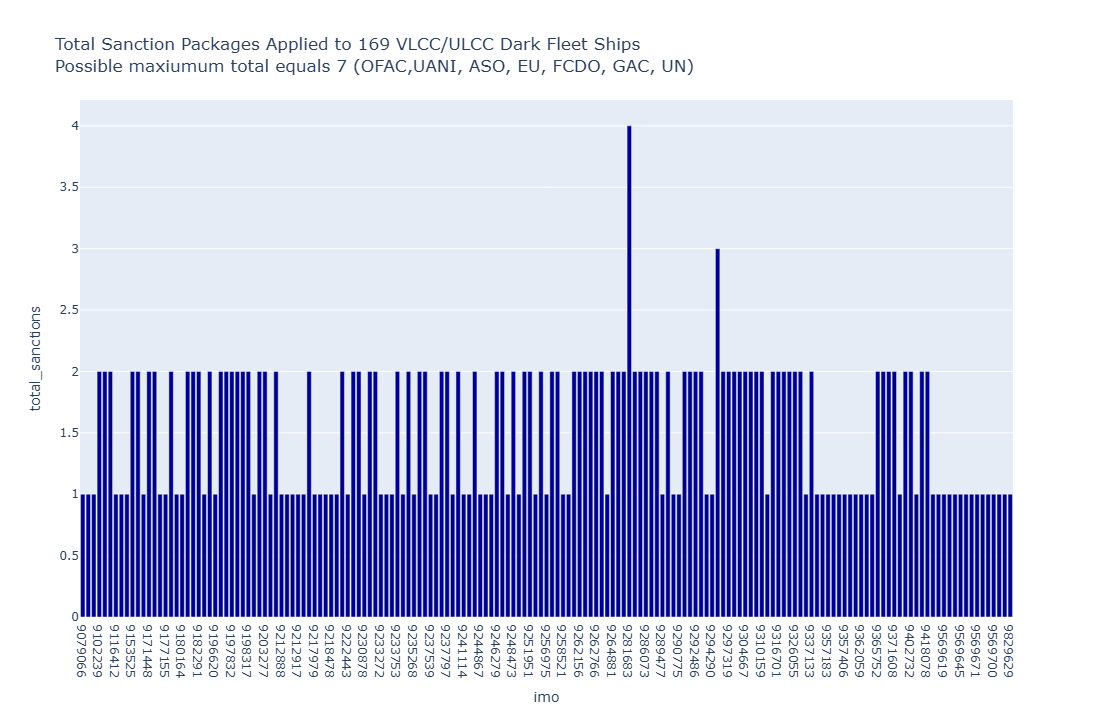

In [27]:
vlcc = df.query('class_size=="VLCC/ULCC"')
vlcc['imo'] = vlcc.imo.astype(str)
vlcc = vlcc.sort_values(by='imo').reset_index(drop=True)
fig = px.bar(vlcc, x='imo', y='total_sanctions', color_discrete_sequence=['darkblue'], title=f"Total Sanction Packages Applied to {vlcc.shape[0]} VLCC/ULCC Dark Fleet Ships<br>"
                                                                      "Possible maxiumum total equals 7 (OFAC,UANI, ASO, EU, FCDO, GAC, UN)")
fig.update_layout(width=1400, height=700)
# fig.update_layout(
#     paper_bgcolor='white',  # Background color of the entire chart
#     plot_bgcolor='white'     # Background color of the plot area
# )

# Show the plot
fig.show()
fig.write_html("VLCC_sanctioned_bodies_interactive_plot.html")


In [ ]:
fig = px.histogram(xxx, x="DWT", color="ship_type")
fig.show()